In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import itertools
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
def txtToDf(chat_file, time_format):
    """
    Converting the txt file that exported from WhatsApp to pandas dataframe
    Parameters:
      chat_file: the group chat that has been exported and will be analyzed.
      time_format: the time format of the export that changes according to the phone language and model. This code contains 2 formats.
        * Format1: DD.MM.YYYY HH:MM
        * Format2: DD/MM/YYYY, HH:MM
    Output:
      df: preprocessed dataframe
    Example:
      df = txtToDf("groupchat.txt", "Format1")
    """

    # Depending on date format of exported txt file
    split_formats = {
        "Format1": "\d{1,2}.\d{1,2}.\d{2,4}\s\d{1,2}:\d{2}\s-\s",  # DD.MM.YYYY HH:MM
        "Format2": "\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s"  # DD/MM/YYYY, HH:MM
    }

    with open(chat_file, "r", encoding="utf-8") as raw_data:
        raw_string = " ".join(raw_data.read().split(
            "\n"))  # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[time_format], raw_string)[
                   1:]  # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[time_format], raw_string)  # finds all the date-time patterns

        df = pd.DataFrame({"date_time": date_time, "user_msg": user_msg})  # exporting it to a df

    # split user and msg
    usernames = []
    messages = []
    for i in df["user_msg"]:
        a = re.split("([\w\W]+?):\s",
                     i)  # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if (a[1:]):  # user typed messages
            usernames.append(a[1])
            messages.append(a[2])
        else:  # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            messages.append(a[0])

    # creating new columns
    df["user"] = usernames
    df["message"] = messages

    # replace links
    df['message'] = df['message'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    df["len_message"] = df["message"].str.len()  # length of messages (by char)
    df["n_words"] = df["message"].str.split().str.len()  # number of words in a message

    # format for converting date_time variable to type datetime
    datetime_format = "%d.%m.%Y %H:%M - "

    # converting date-time pattern which is of type String to type datetime
    df["date_time"] = pd.to_datetime(df["date_time"], format=datetime_format)  # ex. 2022-09-20 22:10:00

    # generating new time variables
    df["date"] = df["date_time"].apply(lambda x: x.date())  # ex. 2022-09-20
    df["year"] = df["date_time"].dt.year  # ex. 2022
    df['month_n'] = df['date_time'].dt.month  # month_numeric ex. 8
    df["month_t"] = df["date_time"].dt.strftime("%b")  # month_text ex. Mar
    df["day_n"] = df["date_time"].dt.day  # day_numeric ex. 14
    df["day_of_week"] = df["date_time"].dt.weekday + 1  # for Mon: 1 - Sun: 7 (org. Mon: 0 - Sun: 6)
    df["day_t"] = df["date_time"].dt.strftime("%a")  # day_text, ex. Tue
    df["time"] = df["date_time"].apply(lambda x: x.time())  # ex. 22:10:00
    df["hour"] = df["date_time"].apply(lambda x: x.hour)  # ex. 22
    df['minute'] = df['date_time'].dt.minute  # ex. 08

    # dropping the old user_msg column.
    df.drop("user_msg", axis=1, inplace=True)
    # dropping the empty messages
    df = df[df['message'] != ""].reset_index(drop=True)
    # dropping "medya dahil edilmedi" messages
    df = df[df["message"] != "<medya dahil edilmedi>"].reset_index(drop=True)
    df = df[df["message"] != "<Medya dahil edilmedi>"].reset_index(drop=True)

    # dropping group_notification messages
    df = df[df['user'] != "group_notification"].reset_index(drop=True)

    # adding extra helper column --> message_count
    df['message_count'] = [1] * df.shape[0]

    return df

In [3]:
df = txtToDf("group_chat_data.txt", "Format1")
df

,date_time,user,message,len_message,n_words,date,year,month_n,month_t,day_n,day_of_week,day_t,time,hour,minute,message_count
0,2022-10-12 11:06:00,Anil,Merabalar,10,1,2022-10-12,2022,10,Oct,12,3,Wed,11:06:00,11,6,1
1,2022-10-12 11:06:00,Cansu,Oooo konserciler toplanmış aksjsj,34,4,2022-10-12,2022,10,Oct,12,3,Wed,11:06:00,11,6,1
2,2022-10-12 11:06:00,Cansu,Merhaba,8,1,2022-10-12,2022,10,Oct,12,3,Wed,11:06:00,11,6,1
3,2022-10-12 11:08:00,Kubra,Heyoooı,8,1,2022-10-12,2022,10,Oct,12,3,Wed,11:08:00,11,8,1
4,2022-10-12 11:08:00,Anil,yav Kubra nereden kaynadı gruba,32,5,2022-10-12,2022,10,Oct,12,3,Wed,11:08:00,11,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-11-12 21:15:00,Cetin,elinize sağlık,15,2,2022-11-12,2022,11,Nov,12,6,Sat,21:15:00,21,15,1
638,2022-11-12 21:15:00,Kubra,Öğren ona göre kdkfkfkfkfkf,28,4,2022-11-12,2022,11,Nov,12,6,Sat,21:15:00,21,15,1
639,2022-11-12 21:15:00,Anil,teşekkür ederim 🥳,18,3,2022-11-12,2022,11,Nov,12,6,Sat,21:15:00,21,15,1
640,2022-11-12 21:24:00,Cansu,Ellerine sağlık güzel olmuş🎉,29,4,2022-11-12,2022,11,Nov,12,6,Sat,21:24:00,21,24,1


In [21]:
def df_general_stats(df, show_print=False):
    """
    General statistics for group chat
    Parameters:
        df: preprocessed group chat dataframe
        show_print: if you want to see statistics with explanations
    Example:
        df_general_stats(df)
    """
    # count of users
    n_users = df["user"].nunique()  # number of people that messaged the group (including those who left the group) (-1 for group notification)
    # list of users
    # user_list = sorted(df["user"].unique().tolist())
    # total number of messages
    n_messages = len(df["message"])
    # number of days since the group was created
    n_days = (datetime.datetime.utcnow() - df.date_time.min()).days
    # average message per day
    avg_message_per_day = n_messages / n_days
    # average number of messages per user
    avg_message_per_user = n_messages / n_users
    # max-min-mean length of messages (by char)
    max_len_message = df["len_message"].max()
    min_len_message = df["len_message"].min()
    avg_len_message = df["len_message"].mean()
    user_max_len_message = df[df["len_message"] == max_len_message][
        "user"].item()  # the person who wrote the longest message of the group
    # max-min-mean length of messages (by word)
    n_words = df["n_words"].sum()
    max_word_message = df["n_words"].max()
    min_word_message = df["n_words"].min()
    avg_words = df["n_words"].mean()

    # if you want the print
    if show_print == True:
        print("number of users:", n_users)
        print("number of messages:", n_messages)
        print("number of days since the group was created:", n_days)
        print("average message per day:", avg_message_per_day)
        print("average message per user:", avg_message_per_user)
        print("maximum char length of messages:", max_len_message)
        print("minimum char length of messages:", min_len_message)
        print("average char length of messages:", avg_len_message)
        print("the person who wrote the longest message:", user_max_len_message)
        print("number of words:", n_words)
        print("maximum word length of messages:", max_word_message)
        print("minimum word length of messages:", min_word_message)
        print("average word length of messages:", avg_words)

    # variable list: n_users, n_messages, n_days, avg_message_per_day, avg_message_per_user, max_len_message, min_len_message, avg_len_message, user_max_len_message, n_words, max_word_message, min_word_message, avg_words
    return n_users, n_messages, n_days, avg_message_per_day, avg_message_per_user, max_len_message, min_len_message, avg_len_message, user_max_len_message, n_words, max_word_message, min_word_message, avg_words

In [22]:
df_general_stats(df, True)

number of users: 5
number of messages: 642
number of days since the group was created: 59
average message per day: 10.88135593220339
average message per user: 128.4
maximum char length of messages: 121
minimum char length of messages: 1
average char length of messages: 23.447040498442366
the person who wrote the longest message: Anil
number of words: 2296
maximum word length of messages: 16
minimum word length of messages: 0
average word length of messages: 3.5763239875389408


(5,
 642,
 59,
 10.88135593220339,
 128.4,
 121,
 1,
 23.447040498442366,
 'Anil',
 2296,
 16,
 0,
 3.5763239875389408)

In [23]:
def daily_conversation_graph(df):
    """
    Create a line plot about number of messages based days
    """

    df1 = df.copy()

    # grouping by date; since plot is of frequency of messages --> no. of messages / day.
    df1 = df1.groupby('date').sum().reset_index()

    # Improving Default Styles using Seaborn
    sns.set_style("darkgrid")

    # For better readablity;
    import matplotlib
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['figure.figsize'] = (27, 6)

    # plot
    plt.plot(df1.date, df1.message_count)
    plt.title('Messages sent per day over a time period');

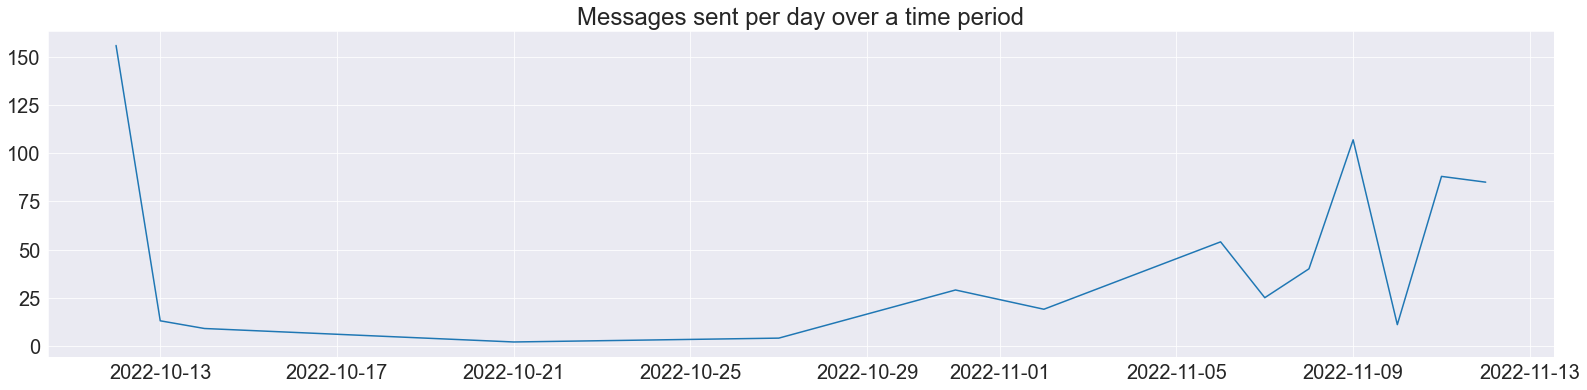

In [24]:
daily_conversation_graph(df)

In [25]:
def top_n_days(df, n = 10):
    """
    most messaged days table
    """
    df2 = df.copy()
    df2 = df2[["date","message_count"]]
    df2 = df2.groupby('date').sum().reset_index()
    topndays = df2.sort_values(by="message_count", ascending=False).head(n)
    topndays.reset_index(inplace=True)
    topndays.drop(columns="index", inplace=True)
    return topndays

def top_n_days_graph(df, n=10):
    """
    most messaged days chart
    """
    topndays = top_n_days(df, n)

    # Improving Default Styles using Seaborn
    sns.set_style("darkgrid")

    # For better readablity;
    import matplotlib
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['figure.figsize'] = (12, 8)

    # A bar plot for top n days
    sns.barplot(topndays.date, topndays.message_count, palette="bright");

In [26]:
top_n_days(df)

,date,message_count
0,2022-10-12,156
1,2022-11-09,107
2,2022-11-11,88
3,2022-11-12,85
4,2022-11-06,54
5,2022-11-08,40
6,2022-10-31,29
7,2022-11-07,25
8,2022-11-02,19
9,2022-10-13,13


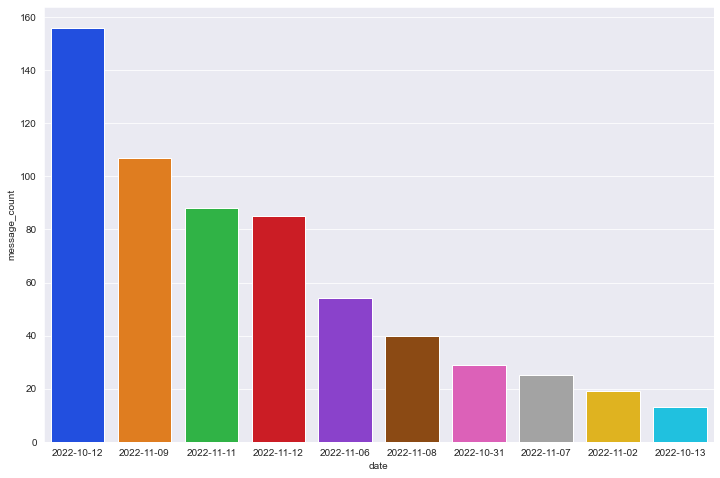

In [27]:
top_n_days_graph(df)

In [6]:
def top_n_user(df, n = 10):
    """
    most messaged users table
    """
    df3 = df.copy()
    df3 = df3[["user","message_count"]]
    df3 = df3.groupby('user').sum().reset_index()
    topnuser = df3.sort_values(by="message_count", ascending=False).head(n)
    topnuser.reset_index(inplace=True)
    topnuser.drop(columns="index", inplace=True)
    return topnuser

def top_n_user_graph(df, n=10):
    """
    most messaged users graph
    """
    topnuser = top_n_user(df, n)

    # Improving Default Styles using Seaborn
    sns.set_style("darkgrid")

    # For better readablity;
    import matplotlib
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['figure.figsize'] = (12, 8)

    # A bar plot for top n user
    sns.barplot(topnuser.user, topnuser.message_count, palette="bright");

In [28]:
top_n_user(df)

,user,message_count
0,Anil,244
1,Kubra,180
2,Cansu,103
3,Metin,58
4,Cetin,57


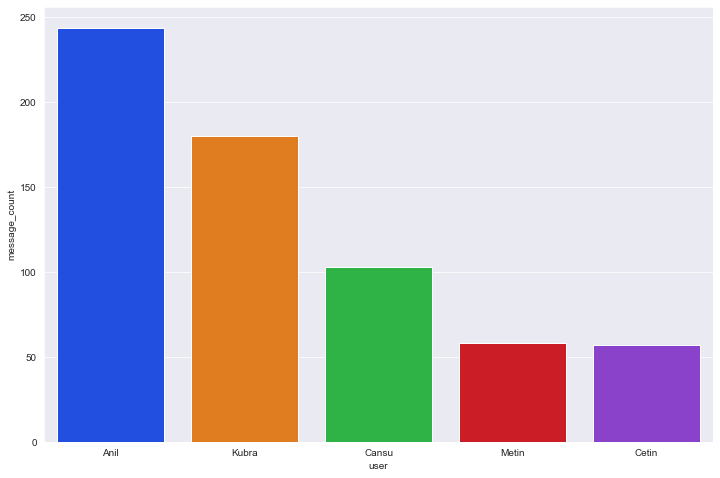

In [29]:
top_n_user_graph(df)

In [7]:
def most_active_hours(df):
    """
    most messaged hours graph
    """
    grouped_by_time = df.copy()

    grouped_by_time = grouped_by_time.groupby('hour').sum().reset_index().sort_values(by = 'hour')

    # Better Readablity
    import matplotlib
    matplotlib.rcParams['font.size'] = 16
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Beautifying Default Styles using Seaborn
    sns.set_style("darkgrid")

    # PLOT: grouped by hour
    sns.barplot(grouped_by_time.hour, grouped_by_time.message_count, palette="bright")
    plt.title('Most Active Hours');

def most_active_weekdays(df):
    """
    most messaged weekdays
    """
    grouped_by_dayt = df.copy()

    grouped_by_dayt = grouped_by_dayt.groupby('day_t').sum().reset_index().sort_values(by = 'day_t')

    # Better Readablity
    import matplotlib
    matplotlib.rcParams['font.size'] = 16
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Beautifying Default Styles using Seaborn
    sns.set_style("darkgrid")

    # PLOT: grouped by hour
    sns.barplot(grouped_by_dayt.day_t, grouped_by_dayt.message_count, palette="bright", order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.title('Most Active Weekdays');

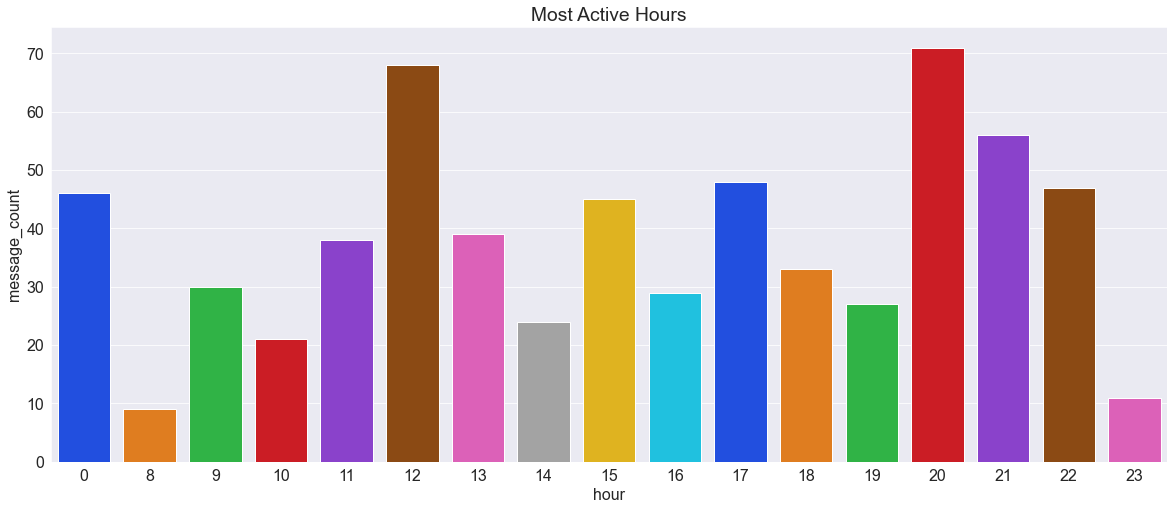

In [30]:
most_active_hours(df)

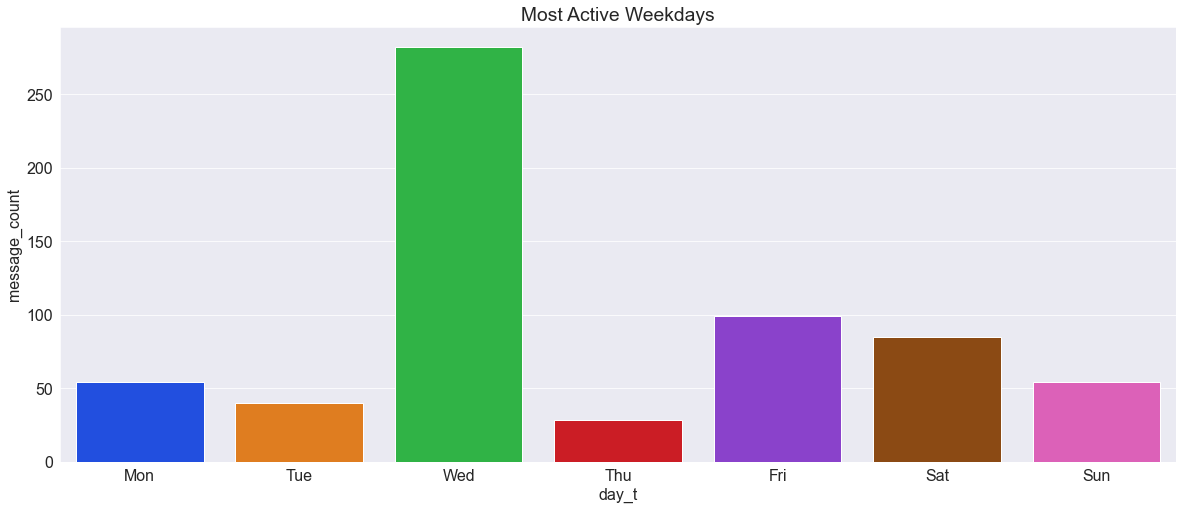

In [32]:
most_active_weekdays(df)

In [8]:
def day_hour_heatmap(df):
    """
    day x hour activity heatmap
    """
    # Better Readablity
    import matplotlib
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['figure.figsize'] = (18, 6)

    # Beautifying Default Styles using Seaborn,
    sns.set_style("darkgrid")

    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

    # Pre-Processing by month and day,
    grouped_by_month_and_day = df.groupby(['day_t', 'hour']).sum().reset_index()[['day_t', 'hour', 'message_count']]

    # creating a pivot table,
    pt = grouped_by_month_and_day.pivot_table(index = 'day_t', columns = 'hour', values = 'message_count').reindex(index = days, columns = hours)

    # PLOT: heatmap.
    sns.heatmap(pt, cmap = 'cividis');
    plt.title('Heatmap of Day of Week sent and Hour sent');

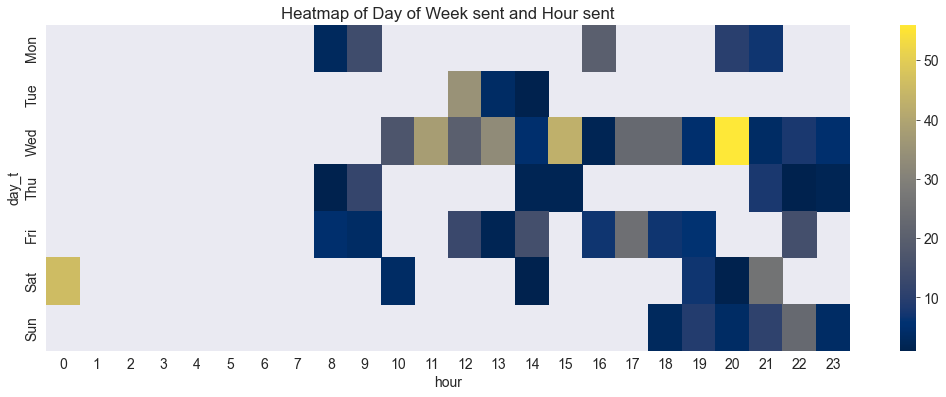

In [33]:
day_hour_heatmap(df)

In [9]:
def word_cloud_all(df):
    """
    word cloud for all messages
    """
    import nltk
    from nltk.corpus import stopwords

    comment_words = ' '

    stopwords = STOPWORDS.update(["bi", "us", "j", "us02web", "silindi", "com", "www",
                                  "ya", "ile", 'medya', 'dahil', 'edilmedi', 'zoom',
                                  'https', "ama", "bu", "da", "mi", "gibi", "için", "ve", "de", "bir"])

    # iterate through the DataFrame.
    for val in df.message.values:
        # typecaste each val to string.
        val = str(val)
        # split the value.
        tokens = val.split()
        # Converts each token into lowercase.
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        for words in tokens:
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 1200, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 8).generate(comment_words)

    return wordcloud.to_image()

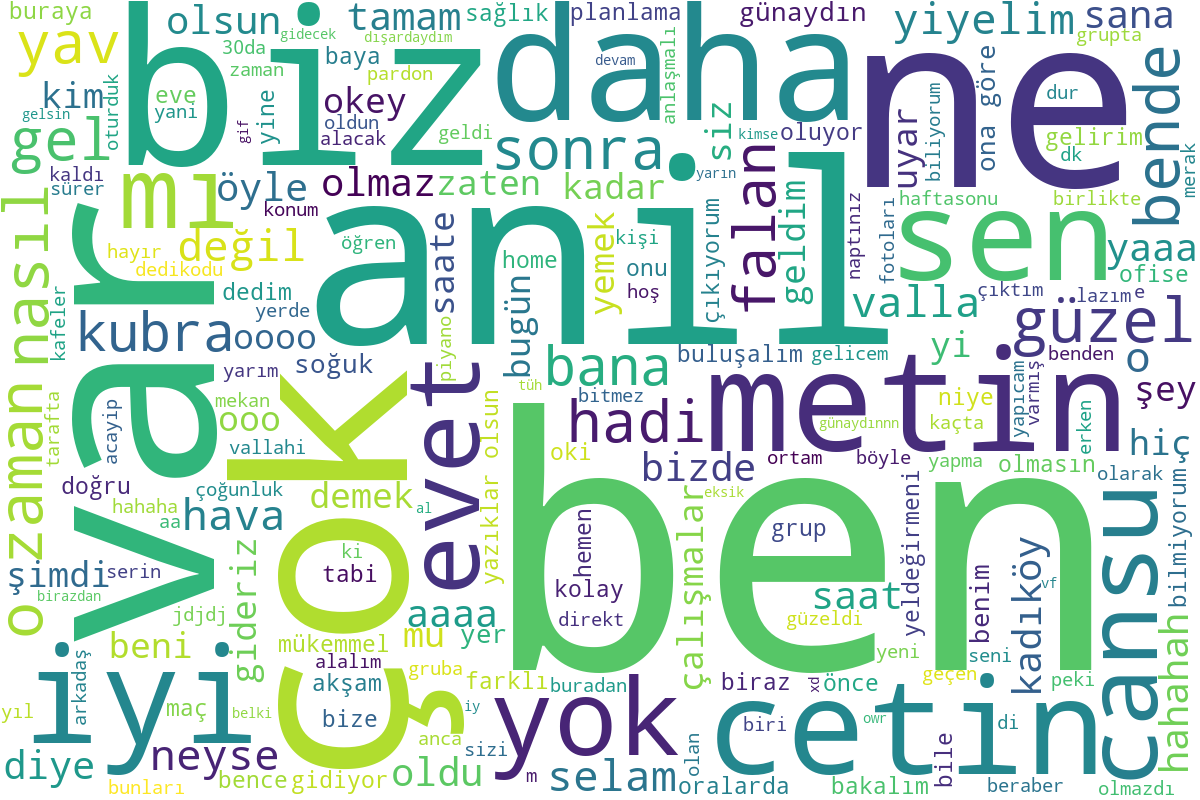

In [34]:
word_cloud_all(df)